In [29]:
import pandas as pd
import os
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from itertools import combinations

from gradio.themes.builder_app import variables

In [7]:
# Step 1: Load the data and create event time variable
file_path = r"D:\Onedrive\Temp\Projects\STOCKAct\regression_data\20240825_stock_act_reg_data.dta"
data = pd.read_stata(file_path).copy()

# Generate the event time variable
data['time_event'] = data['fiscal_year'] - 2012

# Step 2: Create dummies for each event time from -4 to +3
for i in range(0, 4):
    data.loc[:, f'event_{i}'] = (data['time_event'] == i).astype(int)
    data.loc[:, f'event_b{i+1}'] = (data['time_event'] == -i - 1).astype(int)


In [24]:
# Step 3: Run the regression excluding the base year (event_-1)
# Specify interaction terms with ':' and use C() for categorical variables
interaction_terms = [f"event_b{i} * MajorGovCustomer" for i in [3, 2, 1]]
interaction_terms.extend([f"event_{i} * MajorGovCustomer" for i in [0, 1, 2, 3]])

# Define the formula correctly with interaction terms
formula = "log_frequency_w ~ " + " + ".join(interaction_terms) + \
    " + log_market_value_w + lev_w + BM_w + ROA_w + LOSS + EarnVol_w + ret_w + turnover_w + StkVol_w + C(gvkey) + C(year)"

# Fit the model with clustered standard errors at the gvkey level
model = smf.ols(formula, data).fit(cov_type='cluster', cov_kwds={'groups': data['gvkey']})

# Extract coefficients for the event study
coeff_names = [f'event_b{i}:MajorGovCustomer' for i in [3, 2, 1]]
coeff_names.extend([f'event_{i}:MajorGovCustomer' for i in [0, 1, 2, 3]])
coeffs = model.params[coeff_names]
conf_int = model.conf_int().loc[coeff_names]

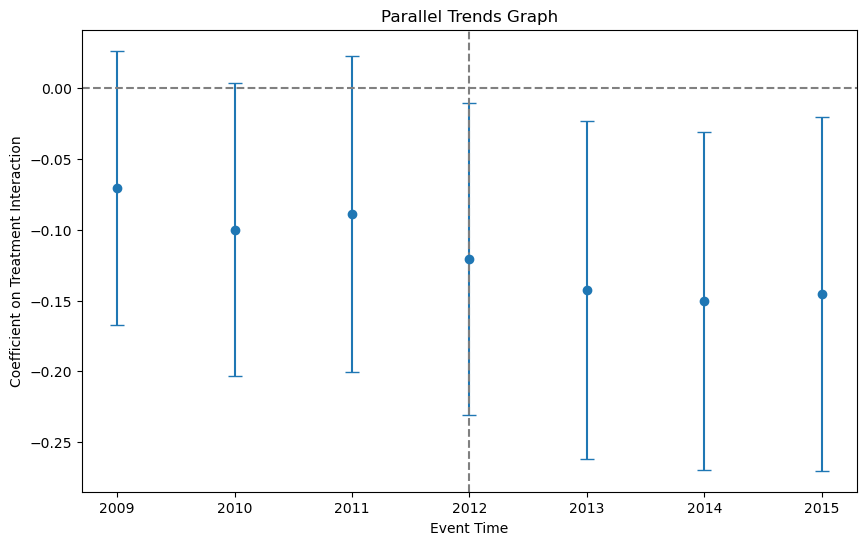

In [25]:
# Step 4: Plot the parallel trends graph
year_labels = { -4: "2008", -3: "2009", -2: "2010", -1: "2011", 
                 0: "2012",  1: "2013",  2: "2014",  3: "2015"}

plt.figure(figsize=(10, 6))
plt.errorbar(x=range(-3, 4), y=coeffs, 
             yerr=[coeffs - conf_int[0], conf_int[1] - coeffs], fmt='o', capsize=5)

plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel("Event Time")
plt.ylabel("Coefficient on Treatment Interaction")
plt.title("Parallel Trends Graph")
plt.xticks(ticks=range(-3, 4), labels=[year_labels[year] for year in [-3, -2, -1, 0, 1, 2, 3]])
plt.show()

In [27]:
print("log_market_value_w + lev_w + BM_w + ROA_w + LOSS + EarnVol_w + ret_w + turnover_w + StkVol_w".split(' + '))

['log_market_value_w', 'lev_w', 'BM_w', 'ROA_w', 'LOSS', 'EarnVol_w', 'ret_w', 'turnover_w', 'StkVol_w']


In [34]:
len(variables)

9

In [35]:
# Try the combinations of control variables to get the best regression results.

variables = ['log_market_value_w', 'lev_w', 'BM_w', 'ROA_w', 'LOSS', 'EarnVol_w', 'ret_w', 'turnover_w', 'StkVol_w']

pic_save_path = r"D:\Users\wangy\Documents\temp\parallel_trending"

i = 0

# Iterate over all possible lengths of combinations (1 to len(variables))
for r in range(7, len(variables) + 1):
    # Generate and print combinations of the current length
    for combo in combinations(variables, r):
        
        # Step 3: Run the regression excluding the base year (event_-1)
        # Specify interaction terms with ':' and use C() for categorical variables
        interaction_terms = [f"event_b{i} * MajorGovCustomer" for i in [2, 1]]
        interaction_terms.extend([f"event_{i} * MajorGovCustomer" for i in [0, 1, 2]])
        
        # Define the formula correctly with interaction terms
        formula = "log_frequency_w ~ " + " + ".join(interaction_terms) + " + " + \
            " + ".join(combo) + " + C(gvkey) + C(year)"
        
        # Fit the model with clustered standard errors at the gvkey level
        model = smf.ols(formula, data).fit(cov_type='cluster', cov_kwds={'groups': data['gvkey']})
        
        # Extract coefficients for the event study
        coeff_names = [f'event_b{i}:MajorGovCustomer' for i in [2, 1]]
        coeff_names.extend([f'event_{i}:MajorGovCustomer' for i in [0, 1, 2]])
        coeffs = model.params[coeff_names]
        conf_int = model.conf_int().loc[coeff_names]
        
        # Step 4: Plot the parallel trends graph
        year_labels = { -4: "2008", -3: "2009", -2: "2010", -1: "2011", 
                         0: "2012",  1: "2013",  2: "2014",  3: "2015"}
        
        plt.figure(figsize=(10, 6))
        plt.errorbar(x=range(-2, 3), y=coeffs, 
                     yerr=[coeffs - conf_int[0], conf_int[1] - coeffs], fmt='o', capsize=5)
        
        plt.axhline(0, color='grey', linestyle='--')
        plt.axvline(0, color='grey', linestyle='--')
        plt.xlabel("Event Time")
        plt.ylabel("Coefficient on Treatment Interaction")
        plt.title(' '.join(combo))
        plt.xticks(ticks=range(-2, 3), labels=[year_labels[year] for year in [-2, -1, 0, 1, 2]])
        
        # Save the plot to a file
        plt.savefig(os.path.join(pic_save_path, 'parallel_trends_graph_{}.png'.format(i)))  # Save as PNG, can also use .pdf, .svg, etc.
        i+=1
        # Do not show the plot
        plt.close()